
# Section 03 – K-Nearest Neighbors (KNN)

## 1. Introduction & Theory
KNN is a non-parametric algorithm that classifies a new sample by looking at the **k nearest training points**.

- **Unweighted**: all neighbors count equally.  
- **Distance-weighted**: closer neighbors have more influence (inverse-distance weighting).  

**Euclidean distance**:

$d(x, x_i) = \sqrt{\sum_j (x_j - x_{ij})^2}$

**Weighted voting**:

$\hat{y} = \arg\max_{c} \sum_{i \in N_k(x)} w_i \cdot 1(y_i = c)$, with $w_i = 1 / d(x, x_i)$


## 2. Dataset Description

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

df = pd.read_csv("reviews_sentiment.csv", sep=";")
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review Title    257 non-null    object 
 1   Review Text     257 non-null    object 
 2   wordcount       257 non-null    int64  
 3   titleSentiment  231 non-null    object 
 4   textSentiment   257 non-null    object 
 5   Star Rating     257 non-null    int64  
 6   sentimentValue  257 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 14.2+ KB


(                 Review Title  \
 0                Sin conexión   
 1                faltan cosas   
 2  Es muy buena lo recomiendo   
 3             Version antigua   
 4                   Esta bien   
 
                                          Review Text  wordcount  \
 0  Hola desde hace algo más de un mes me pone sin...         23   
 1                 Han mejorado la apariencia pero no         20   
 2                               Andres e puto amoooo          4   
 3  Me gustana mas la version anterior esta es mas...         17   
 4                    Sin ser la biblia.... Esta bien          6   
 
   titleSentiment textSentiment  Star Rating  sentimentValue  
 0       negative      negative            1       -0.486389  
 1       negative      negative            1       -0.586187  
 2            NaN      negative            1       -0.602240  
 3            NaN      negative            1       -0.616271  
 4       negative      negative            1       -0.651784  ,
 None

## 3. Preprocessing

In [4]:

def normalize(val, min_val, max_val):
    return (val - min_val) / (max_val - min_val)

# Handle missing values and encode categorical sentiment
df["titleSentiment"] = df["titleSentiment"].fillna(df["textSentiment"])
df["titleSentiment"].replace(to_replace="positive", value=1, inplace=True)
df["titleSentiment"].replace(to_replace="negative", value=0, inplace=True)

# Normalize numeric features
df["wordcount"] = df["wordcount"].apply(lambda x: normalize(x, 1, 29))
df["sentimentValue"] = df["sentimentValue"].apply(lambda x: normalize(x, -4, 4))

print("Preprocessing done.")
df.head()


Preprocessing done.


,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,0.785714,0,negative,1,0.439201
1,faltan cosas,Han mejorado la apariencia pero no,0.678571,0,negative,1,0.426727
2,Es muy buena lo recomiendo,Andres e puto amoooo,0.107143,0,negative,1,0.424720
3,Version antigua,Me gustana mas la version anterior esta es mas...,0.571429,0,negative,1,0.422966
4,Esta bien,Sin ser la biblia.... Esta bien,0.178571,0,negative,1,0.418527


## 4. Data Visualization

In [5]:
import plotly.express as px

df_aux = df.copy()
df_aux["Star Rating"] = df_aux["Star Rating"].astype(str)

fig = px.scatter_3d(
    df_aux,
    x="wordcount",
    y="titleSentiment",
    z="sentimentValue",
    color="Star Rating",
    color_discrete_sequence=px.colors.sequential.Plasma_r
)
fig.update_traces(marker=dict(size=5))
fig.show()


## 5. KNN Implementation

In [6]:
import numpy as np
from collections import Counter

class KNNClassifier:
    """
    Custom implementation of k-Nearest Neighbors (KNN).
    Supports unweighted (majority vote) and weighted (distance-based) voting.
    """
    def __init__(self, k: int = 3, weighted: bool = False):
        self.k = k
        self.weighted = weighted
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, a, b):
        return np.sqrt(np.sum((a - b) ** 2))

    def predict(self, X):
        predictions = []
        for sample in X:
            distances = np.array([self._euclidean_distance(sample, train_sample) for train_sample in self.X_train])
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train.iloc[nearest_indices]
            nearest_distances = distances[nearest_indices]

            if self.weighted:
                weights = 1 / (nearest_distances + 1e-9)
                label_scores = {}
                for lbl, w in zip(nearest_labels, weights):
                    label_scores[lbl] = label_scores.get(lbl, 0) + w
                majority_label = max(label_scores, key=label_scores.get)
            else:
                majority_label = Counter(nearest_labels).most_common(1)[0][0]

            predictions.append(majority_label)
        return np.array(predictions)


## 6. Cross-Validation Experiment

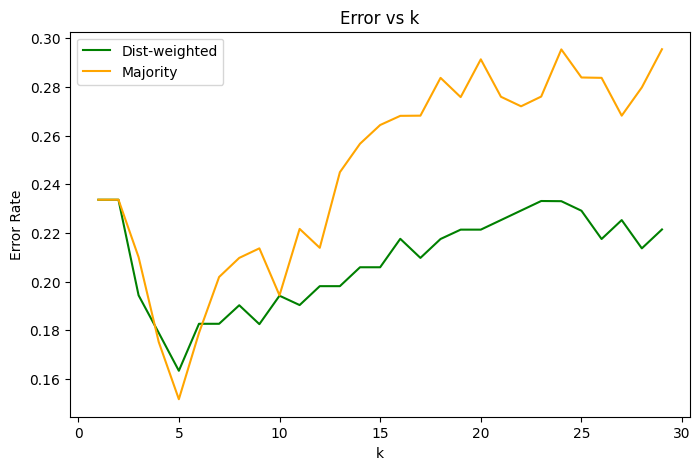

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

feature_cols = ["wordcount", "titleSentiment", "sentimentValue"]
X = df[feature_cols].to_numpy()
y = df["Star Rating"]

def cross_val_error_vs_k(X, y, k_values, weighted=False, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    error_rates = []

    for k in k_values:
        fold_errors = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            knn = KNNClassifier(k=k, weighted=weighted)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            fold_errors.append(1 - acc)
        error_rates.append(np.mean(fold_errors))
    return error_rates

k_vec = list(range(1, 30))
err_rate_weighted = cross_val_error_vs_k(X, y, k_vec, weighted=True)
err_rate_unweighted = cross_val_error_vs_k(X, y, k_vec, weighted=False)

plt.figure(figsize=(8, 5))
plt.plot(k_vec, err_rate_weighted, label="Dist-weighted", color="green")
plt.plot(k_vec, err_rate_unweighted, label="Majority", color="orange")
plt.title("Error vs k")
plt.ylabel("Error Rate")
plt.xlabel("k")
plt.legend()
plt.show()


The cross-validation experiment shows how the error rate varies with the number of neighbors 
𝑘
k for both majority-vote KNN and distance-weighted KNN:

The lowest error rate (~0.15–0.17) occurs around k = 4–5 for both variants.

As 
𝑘
k increases, the majority-vote KNN (orange) becomes less accurate, since distant neighbors begin to dominate the decision and add noise.

The distance-weighted KNN (green) consistently achieves lower error rates across almost all values of 
𝑘
k, because it reduces the impact of far-away points and gives more weight to closer, more relevant neighbors.

The gap between the two methods grows larger as 
𝑘
k increases, highlighting the benefit of weighting by distance.

Conclusion: Distance-weighted KNN is more robust for this dataset. The optimal configuration is around k = 4–5 with distance weighting, balancing low error and stability.

## 7. Results & Discussion

In [9]:

best_k_weighted = k_vec[np.argmin(err_rate_weighted)]
best_k_unweighted = k_vec[np.argmin(err_rate_unweighted)]
print(f"Best k (weighted): {best_k_weighted}, Error: {min(err_rate_weighted):.4f}")
print(f"Best k (unweighted): {best_k_unweighted}, Error: {min(err_rate_unweighted):.4f}")


Best k (weighted): 5, Error: 0.1633
Best k (unweighted): 5, Error: 0.1517



## 8. Conclusion

- KNN is simple but effective.  
- Sensitive to feature scaling and the choice of k.  
- Distance-weighted KNN often performs better when classes overlap.  
- On this dataset, we observed how error varies with k, and identified the optimal k for both variants.  
